In [1]:
include("Mondrian_Forest_Classifier.jl")
using Plots

In [42]:
using MLBase
function Fakedata(n,dim) 
    x = randn(n,dim)
    y = (sum(exp.(x)/(1+exp.(x)),2)).>0.5
    return 1.0*x,1*y[:,1]
end

d=2
X, Y = Fakedata(100,d);
D = (X,Y.+1)

x,y = Fakedata(10,d)
D_test = (x,y.+1)

# t = y.==1;

# using Plots
# scatter(x[t.==1,1],x[t.==1,2])
# scatter!(x[t.==0,1],x[t.==0,2])

In [47]:
MT = Mondrian_Tree()
train!(MT,D[1],D[2],1e1)
pred=predict!(MT, D[1])
println("Train Accuracy")
println(correctrate(D[2],convert(Array{Int,1},pred)))
pred=predict!(MT, D_test[1])
println("Accuracy") 
println(correctrate(D_test[2],convert(Array{Int,1},pred)))

Train Accuracy
0.92
Accuracy
0.9


In [4]:
MF = Mondrian_Forest_Classifier(100)
train!(MF, D[1], D[2], 1e9)
pred=predict!(MF, D[1]);
println("Train Accuracy")
println(correctrate(D[2],convert(Array{Int,1},pred)))
pred=predict!(MF, D_test[1])
println("Accuracy") 
println(correctrate(D_test[2],convert(Array{Int,1},pred)))

Train Accuracy
0.9
Accuracy
0.73


In [34]:
function show_mondrian_split_2d(MT::Mondrian_Tree, times=false)
    plot()
    τ = []
    ζ = []
    δ = []
    nodes = []
    push!(τ,get(MT.root).τ)
    push!(ζ,get(get(MT.root).ζ))
    push!(δ,get(get(MT.root).δ))
    push!(nodes, get(MT.root))
    for l in MT.leaves
        j = get(l.parent)
        while j.node_type[3] != true
            if (j in nodes)
                break
            end
            push!(τ, j.τ)
            push!(ζ, get(j.ζ))
            push!(δ, get(j.δ))
            push!(nodes,j)
            j = get(j.parent)
        end
    end
    indices = sortperm(τ)
    τ = τ[indices]
    ζ = ζ[indices]
    δ = δ[indices] 
    nodes = nodes[indices]
    for i in 1:size(ζ,1)
        int = get(nodes[i].Θ_draw).Intervals
        if times
            label = round(τ[i],3)
        else
            label = ""
        end
        if (δ[i] == 1)
            x = linspace(int[2,1],int[2,2],20)
            plot!(fill(ζ[i],length(x)),x,show=true, label="")
            annotate!([(ζ[i], median(x), text(label,6))])
        else
            x = linspace(int[1,1],int[1,2],20)
            plot!(x,fill(ζ[i],length(x)),show=true, label="")
            annotate!([(median(x),ζ[i], text(label,6))])
        end
    end
    int = get(nodes[1].Θ_draw).Intervals
    xlims!(int[1,1],int[1,2])
    ylims!(int[2,1],int[2,2])
    title!("Mondrian Tree Partitions")
#     xlabel!("Dimension 1")
#     ylabel!("Box dimension 2")
end

show_mondrian_split_2d (generic function with 2 methods)

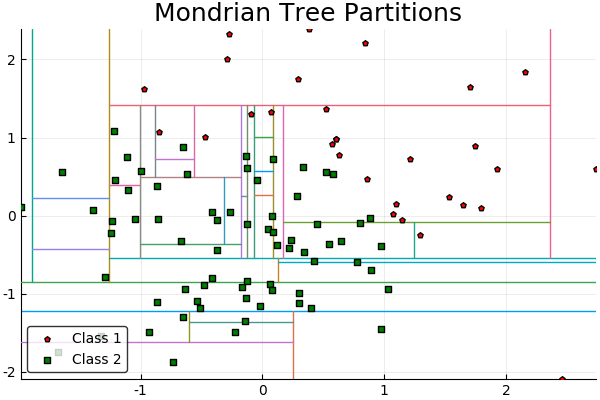

In [48]:
show_mondrian_split_2d(MT)
t = Y.==1;
scatter!(X[t.==1,1],X[t.==1,2], color="red", label="Class 1", markershape=:auto)
scatter!(X[t.==0,1],X[t.==0,2], color="green", label="Class 2", markershape=:square)
plot!(legend =:bottomleft)
#savefig("part")

In [50]:
plot!(legend =:bottomright)
savefig("part")

In [9]:
d=5
X, Y = Fakedata(1000,d);
D = (X,Y.+1)

x,y = Fakedata(100,d)
D_test = (x,y.+1)

([1.3203 -0.753642 … -0.623877 0.282334; 0.0360151 0.653261 … 1.11249 1.02628; … ; 0.865624 -0.318692 … 0.368154 -0.21278; -0.944525 0.831754 … 1.63471 -0.186261], [2, 2, 2, 1, 2, 1, 2, 2, 1, 1  …  2, 2, 1, 1, 1, 2, 2, 1, 1, 2])

In [10]:
time = []
acc = []
x = []
for i in collect(1:9)
    println(2^i)
    push!(x,2^i)
    MF = Mondrian_Forest_Classifier(2^i)
    t = (@timed train!(MF, D[1], D[2], 1e9))[2]
    push!(time,t)
    pred=predict!(MF, D_test[1]);
    push!(acc,correctrate(D_test[2],convert(Array{Int,1},pred)))
end

2
4
8
16
32
64
128
256
512


In [11]:
println(time)
println(acc)

Any[0.959011, 0.24629, 0.649824, 0.774067, 2.02488, 4.40358, 9.47458, 21.0614, 42.567]
Any[0.78, 0.82, 0.75, 0.84, 0.81, 0.82, 0.82, 0.82, 0.81]


In [12]:
using JuliaDB
times_py = loadtable("times_py")
times_py = columns(times_py)[2]

9-element Array{Float64,1}:
   0.810814
   0.847467
   2.28629 
   4.0544  
   7.72888 
  16.0861  
  30.8925  
  62.0707  
 134.365   

In [19]:
#Plots.scalefontsizes(0.5)
plot(x,times_py,label="Python")
plot!(x,time,label="Julia")
scatter!(x,times_py,label="")
scatter!(x,time,label="",markershape=:auto)
title!("Scaling of training time with the number \n of trees in a Mondrian forest classifier")
xlabel!("Number of trees")
ylabel!("Training time (seconds)")
savefig("n_tree_scale")

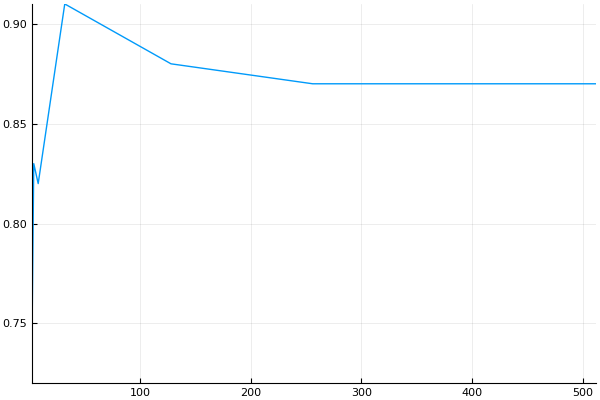

In [123]:
plot(x,acc,label="")

In [210]:
time2 = []
n = []
acc2 =[]

for i in collect(1:14)
    println(2^i)
    push!(n,2^i)
    X, Y = Fakedata(2^i,5)
    #x,y = Fakedata(100,5)
    MF = Mondrian_Forest_Classifier(50)
    t = (@timed train!(MF, X, Y, 1e9))[2]
    push!(time2, t)
    #pred=predict!(MF, x);
    #push!(acc,correctrate(y,convert(Array{Int,1},pred)))
end

2
4
8
16
32
64
128
256
512
1024
2048
4096
8192
16384


In [213]:
times_py_d = loadtable("times_py_d")
times_py_d = columns(times_py_d)[2]

14-element Array{Float64,1}:
   0.00788927
   0.020139  
   0.0397062 
   0.0687733 
   6.5054    
   0.405493  
   1.00915   
   2.18418   
   5.09597   
  11.7887    
  26.9763    
  62.0618    
 142.517     
 323.138     

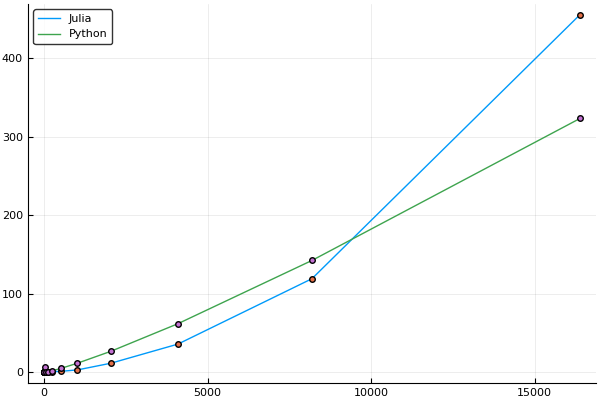

In [215]:
plot(n,time2, label="Julia")
scatter!(n,time2, label="")
plot!(n,times_py_d, label="Python")
scatter!(n,times_py_d, label="")

In [236]:
time2

14-element Array{Any,1}:
   0.00524102
   0.00969266
   0.0197662 
   0.0531366 
   0.0702604 
   0.142468  
   0.337263  
   0.966114  
   1.45101   
   3.26097   
  11.793     
  36.1138    
 119.283     
 455.166     

In [228]:
CSV.write("julia_time_d.csv",time2)

LoadError: [91mArgumentError: `source` doesn't support the supported streaming types of `sink`: DataType[DataStreams.Data.Field][39m

In [218]:
plot(n,acc2)

DivideError: [91mDivideError: integer division error[39m